<h1>House Price and Average Salary analysis</h1>

by Ben Walker, 27 July 2023, First Draft.

This is notebook analyse's a dataset from Kaggle which contains average house prices and salaries from 1975 to 2020.

In [1]:
#Module Imports
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math
from scipy.stats import spearmanr

#Formatting Options
%matplotlib inline
%pip install --upgrade plotly
pd.options.display.float_format = '{:,.2f}'.format

Note: you may need to restart the kernel to use updated packages.


<h2>Getting and preparing the data</h2>
The data has been obtained from Kaggle and includes average House prices and salaries in the UK between 1975 and 2020. In this section the dataset will be reviewed and cleaned to ensure the data is in a good state to analyse. Redundant columns will be removed, data types updated and the data will be checked for consistency.

The first two cells import the dataset from the CSV file and shows the top 5 rows.

In [2]:
#This provides a constant variable for the CSV.
LOCATION1 = 'Average_UK_houseprices_and_salary.csv'
LOCATION2 = 'Income_by_age_and_gender.csv'

In [3]:
#Create the dataset and display the first five rows.
df_house = pd.read_csv(LOCATION1)
df_house.head()

,Year,Average house price adj. by inflation (pounds),Median Salary adj. by inflation (pounds),Unnamed: 3
0,1975,94983,NaN,NaN
1,1976,89281,NaN,NaN
2,1977,85028,NaN,NaN
3,1978,100519,NaN,NaN
4,1979,112067,NaN,NaN


In [4]:
#Create the dataset and display the first five rows.
df_income = pd.read_csv(LOCATION2)
df_income

,Age group,Median salary (pounds),Gender
0,18 to 21,18392,Male
1,22 to 29,26856,Male
2,30 to 39,34210,Male
3,40 to 49,38463,Male
4,50 to 59,36000,Male
5,60 and over,30944,Male
6,18 to 21,17005,Female
7,22 to 29,25115,Female
8,30 to 39,30540,Female
9,40 to 49,31679,Female


In [5]:
#Find column datatypes for df_house
print(df_house.dtypes)

Year                                                int64
Average house price adj. by inflation (pounds)      int64
Median Salary adj. by inflation (pounds)          float64
Unnamed: 3                                        float64
dtype: object


In [6]:
#Find column datatypes for df_income
print(df_income.dtypes)

Age group                 object
Median salary (pounds)     int64
Gender                    object
dtype: object


In [7]:
#Change the "object" datatypes to something more useful, in this case String.
for column in df_income.columns:
    if df_income[column].dtype.kind == "O":
        df_income[column] = df_income[column].astype('string')
print(df_income.dtypes)

Age group                 string
Median salary (pounds)     int64
Gender                    string
dtype: object


In [8]:
#Find NULL values for df_house
df_house.isnull().sum()

Year                                               0
Average house price adj. by inflation (pounds)     0
Median Salary adj. by inflation (pounds)          24
Unnamed: 3                                        46
dtype: int64

In [9]:
#Find NULL values for df_income
df_income.isnull().sum()

Age group                 0
Median salary (pounds)    0
Gender                    0
dtype: int64

In [44]:
#Review NULL values found in df_house
df_house(5)

TypeError: 'DataFrame' object is not callable

As you can see from the df_house dataset above we do not have Median salary data for years 1975 to 2020. We also have a redundant column. in the following cells we will drop the redundant column and we will create a new dataset for the median salary just including data from 1999 to 2020.

In [11]:
#Drop redundant column from dataset
df_house = df_house.drop('Unnamed: 3', axis=1)
print(df_house.columns)

Index(['Year', 'Average house price adj. by inflation (pounds)',
       'Median Salary adj. by inflation (pounds)'],
      dtype='object')


In [12]:
df_salary = df_house.loc[df_house['Year'] >= 1999]
df_salary = df_salary.drop('Average house price adj. by inflation (pounds)', axis=1)
df_salary.head()

,Year,Median Salary adj. by inflation (pounds)
24,1999,"31,551.55"
25,2000,"32,443.92"
26,2001,"33,357.50"
27,2002,"33,898.44"
28,2003,"34,155.19"


In [24]:
#df_house = df_house.drop('Median Salary adj. by inflation (pounds)', axis = 1)
df_house = df_house.rename(columns={"Average house price adj. by inflation (pounds)": "Average House Price"})
df_house = df_house.set_index("Year")
df_house.head()

,Average House Price
Year,
1975,94983
1976,89281
1977,85028
1978,100519
1979,112067


We now have three datasets. df_house which provides the average house prices for years 1975 to 2020. df_salary which provides median salary between years 1999 and 2020. Finally we have df_income which contains median salary vs age group and male/female.

<h1>Analysis</h1>

The following questions will be answered in this section of the analysis.
<ul>
    <li>How have house prices changed over time?</li>
    <li>How have Salaries changed over time?</li>
    <li>Is there any correlation between average house prices and average salaries?</li>
    <li>How do salaries for males differ from salaries for females?</li>
    <li>How do salaries change by age group?</li>
    <li>How do salaries for age groups compare between males and females?</li>
    <li>What the multiplication factor of salary to house price?</li>
    <li>How has the multiplication factor changed over time?</li>
</ul>

The following cells will analyse the data to produce answers to the questions above.

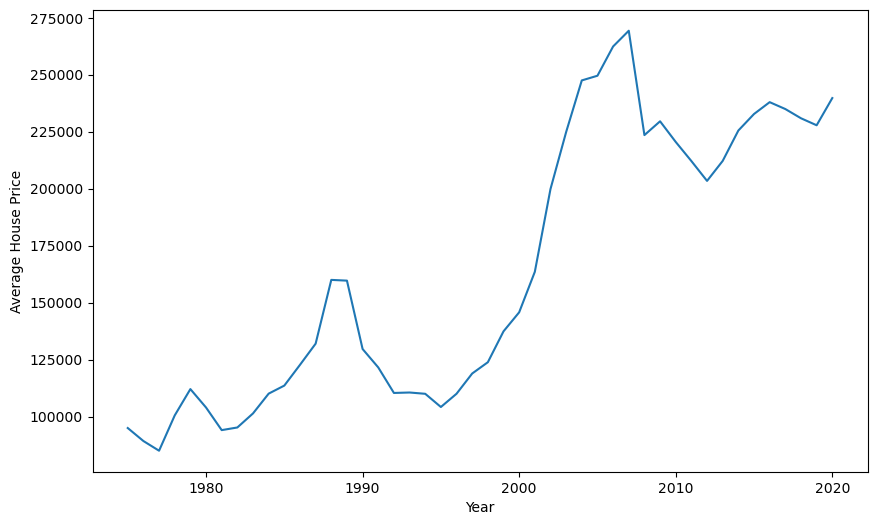

In [30]:
fig = plt.figure(figsize=(10,6))
plt.plot(df_house.index, df_house['Average House Price'])
plt.xlabel('Year')
plt.ylabel('Average House Price')

plt.show()


In [33]:
df_salary = df_salary.rename(columns={"Median Salary adj. by inflation (pounds)": "Average Salary"})
df_salary = df_salary.set_index("Year")
df_salary.head(5)

KeyError: "None of ['Year'] are in the columns"

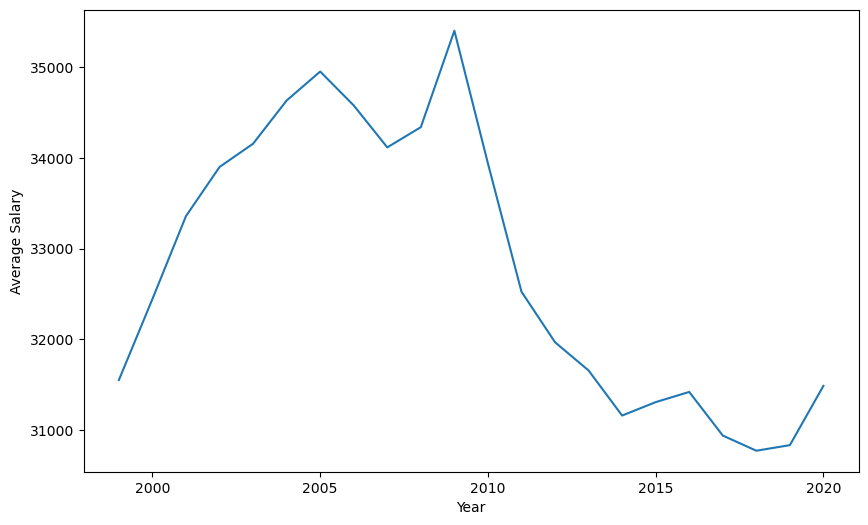

In [35]:
fig = plt.figure(figsize=(10,6))
plt.plot(df_salary.index, df_salary['Average Salary'])
plt.xlabel('Year')
plt.ylabel('Average Salary')

plt.show()

In [41]:
df_house_filtered = df_house.query("Year >= 1999")

print(df_house_filtered)

      Average House Price
Year                     
1999               137401
2000               145756
2001               163517
2002               199821
2003               224849
2004               247493
2005               249549
2006               262390
2007               269297
2008               223507
2009               229553
2010               220496
2011               212111
2012               203407
2013               212183
2014               225514
2015               232759
2016               237955
2017               234936
2018               230887
2019               227812
2020               239753


In [43]:
correlation = np.corrcoef(df_house_filtered["Average House Price"], df_salary["Average Salary"])[0, 1]
(correlation, pValue) = spearmanr(df_house_filtered["Average House Price"], df_salary["Average Salary"])
print('The correlation is', correlation)
if pValue < 0.05:
    print('It is statistically significant.')
else:
    print('It is not statistically significant.')

The correlation is 0.13833992094861663
It is not statistically significant.


In [46]:
df_income.head(5)

,Age group,Median salary (pounds),Gender
0,18 to 21,18392,Male
1,22 to 29,26856,Male
2,30 to 39,34210,Male
3,40 to 49,38463,Male
4,50 to 59,36000,Male


In [55]:
df_income.head(10)
df_income_grouped = df_income.groupby("Age group")


In [56]:
df_income_grouped.head()

,Age group,Median salary (pounds),Gender
0,18 to 21,18392,Male
1,22 to 29,26856,Male
2,30 to 39,34210,Male
3,40 to 49,38463,Male
4,50 to 59,36000,Male
5,60 and over,30944,Male
6,18 to 21,17005,Female
7,22 to 29,25115,Female
8,30 to 39,30540,Female
9,40 to 49,31679,Female
